# Twitter Classification using Scikit-learn

Classifying short messages into five categories. We will prepare our dataset (nltk and regular expressions) and vectorize words using TF-IDF (term frequency-inverse document frequency) metric. Later we will use classifiers provided by scikit-learn and classify sentences into five categories: 5 - very positive

4 - slightly positive

3 - neutral

2 - slightly negative

1 - very negative

# cleaning test.csv file

In [30]:
import pandas as pd
test_data=pd.read_csv('test.csv', encoding= 'unicode_escape')
test_data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,sentiment,sentiment:confidence,our_id,sentiment_gold,sentiment_gold_reason,text
0,724227031,True,golden,236,NaN,5,0.7579,10001,5\n4,Author is excited about the development of the...,Two places I'd invest all my money if I could:...
1,724227032,True,golden,231,NaN,5,0.8775,10002,5\n4,Author is excited that driverless cars will be...,Awesome! Google driverless cars will help the ...
2,724227033,True,golden,233,NaN,2,0.6805,10003,2\n1,The author is skeptical of the safety and reli...,If Google maps can't keep up with road constru...
3,724227034,True,golden,240,NaN,2,0.8820,10004,2\n1,The author is skeptical of the project's value.,Autonomous cars seem way overhyped given the t...
4,724227035,True,golden,240,NaN,3,1.0000,10005,3,Author is making an observation without expres...,Just saw Google self-driving car on I-34. It w...


In [31]:
test_data=test_data[['text','sentiment']]


In [32]:
test_data.isnull().sum()

text         0
sentiment    0
dtype: int64

In [33]:
test_data.sentiment.unique()


array(['5', '2', '3', 'not_relevant', '1', '4'], dtype=object)

In [34]:
test_data.drop(test_data[test_data['sentiment'] == 'not_relevant'].index, inplace = True)
test_data.sentiment.unique()


array(['5', '2', '3', '1', '4'], dtype=object)

In [35]:
test_data.to_csv('Testdata.csv')

# Workflow

* Text Preprocessing
* Text Representation
* Classifiers: Naive Bayes, Linear Regression, Random Rorrrest, SVM
* Evaluation: F1 scores and Confussion Matrix
* Saving the Model

In [50]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# save and load a file
import pickle

# 1. Import Dataset

In [51]:
df_train = pd.read_csv('Testdata.csv',encoding = 'unicode_escape')
df_test = pd.read_csv('train.csv',encoding = 'unicode_escape')

X_train = df_train.text
X_test = df_test.text

y_train = df_train.sentiment
y_test = df_test.sentiment

class_names = ['very positive', 'slightly positive', 'neutral', 'slightly negative', 'very negative']
data = pd.concat([df_train, df_test])

print('size of training set: %s' % (len(df_train['text'])))
print('size of validation set: %s' % (len(df_test['text'])))
print(data.sentiment.value_counts())

data.head()

size of training set: 6943
size of validation set: 981
3    4848
4    1623
2     802
5     518
1     133
Name: sentiment, dtype: int64


,Unnamed: 0,text,sentiment
0,0.0,Two places I'd invest all my money if I could:...,5
1,1.0,Awesome! Google driverless cars will help the ...,5
2,2.0,If Google maps can't keep up with road constru...,2
3,3.0,Autonomous cars seem way overhyped given the t...,2
4,4.0,Just saw Google self-driving car on I-34. It w...,3


In [52]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
     
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# 2. Text Preprocessing



* Removing noise: html markups, urls, non-ascii symbols, trailing whitespace etc.
* Removing punctuation
* Normalizing emoticons
* Negation handling
* Tokenization: split text into word tokens
* Stopword removal
*Stemming or lemmatization

However, most of these steps did not improve our classification results. Since our data was mostly taken from written dialogs it was almost ready to use.

In [53]:
def preprocess_and_tokenize(data):    

    #remove html markup
    data = re.sub("(<.*?>)", "", data)

    #remove urls
    data = re.sub(r'http\S+', '', data)
    
    #remove hashtags and @names
    data= re.sub(r"(#[\d\w\.]+)", '', data)
    data= re.sub(r"(@[\d\w\.]+)", '', data)

    #remove punctuation and non-ascii digits
    data = re.sub("(\\W|\\d)", " ", data)
    
    #remove whitespace
    data = data.strip()
    
    # tokenization with nltk
    data = word_tokenize(data)
    
    # stemming with nltk
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]
        
    return stem_data

In [54]:
>>> import nltk
>>> nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 3. Text Representation
Vectorizing text using Term Frequency technique (Term Frequency(TF) — Inverse Dense Frequency(IDF))

* Tekenize with our preprocess_and_tokenize
* Find it’s TF = (Number of repetitions of word in a document) / (# of words in a document)
* IDF = log(# of documents / # of documents containing the word)

In [55]:
# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

# fit on our complete corpus
vect.fit_transform(data.text)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

# 4. Classifiers
## Naive Bayes

Accuracy: 62.28%

F1 Score: 62.28

COnfusion Matrix:
 [[  0   0  23   0   0]
 [  0   0 117   0   0]
 [  0   0 602   1   0]
 [  0   0 170   9   0]
 [  0   0  58   1   0]]


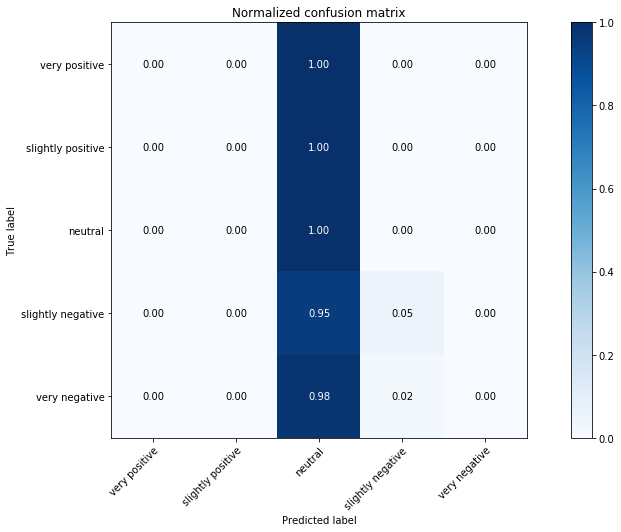

In [56]:
nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

ynb_pred = nb.predict(X_test_vect)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ynb_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ynb_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ynb_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, ynb_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Random Forrest

Accuracy: 99.59%

F1 Score: 99.59

COnfusion Matrix:
 [[ 22   0   1   0   0]
 [  0 116   1   0   0]
 [  0   0 602   1   0]
 [  0   0   0 178   1]
 [  0   0   0   0  59]]


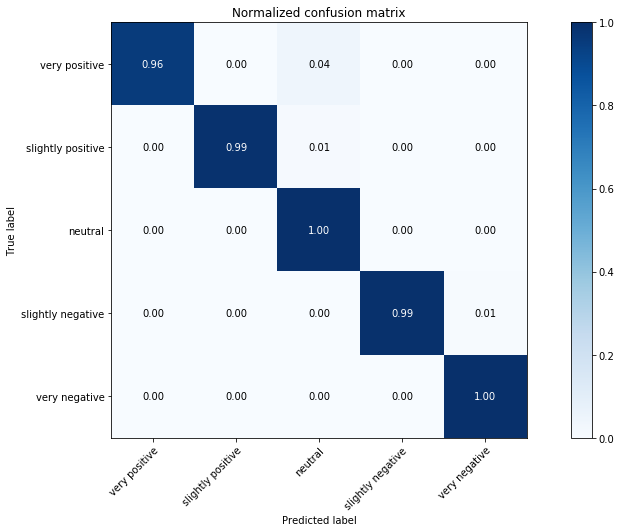

In [57]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train_vect, y_train)

yrf_pred = rf.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, yrf_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, yrf_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, yrf_pred))

plot_confusion_matrix(y_test, yrf_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Logistic Regression

Accuracy: 74.01%

F1 Score: 74.01

COnfusion Matrix:
 [[  0   2  18   3   0]
 [  0  24  92   1   0]
 [  0   0 602   1   0]
 [  0   0  88  89   2]
 [  0   0  37  11  11]]


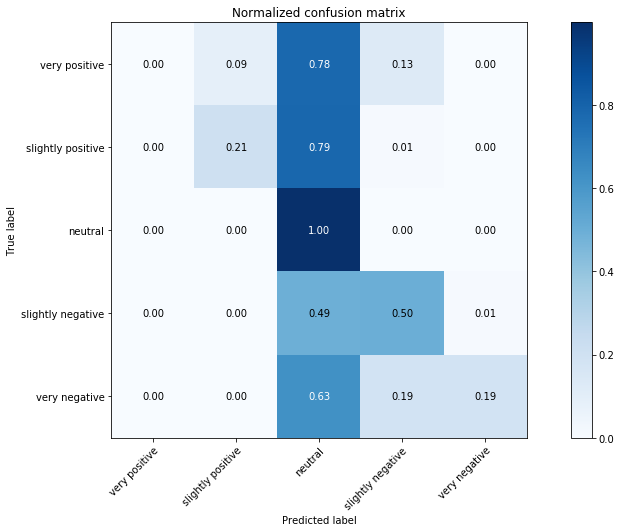

In [58]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ylog_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ylog_pred))

plot_confusion_matrix(y_test, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

# Support Vector Machine

Accuracy: 99.18%

F1 Score: 99.18

COnfusion Matrix:
 [[ 23   0   0   0   0]
 [  0 116   1   0   0]
 [  0   0 602   1   0]
 [  0   0   0 177   2]
 [  0   0   1   3  55]]


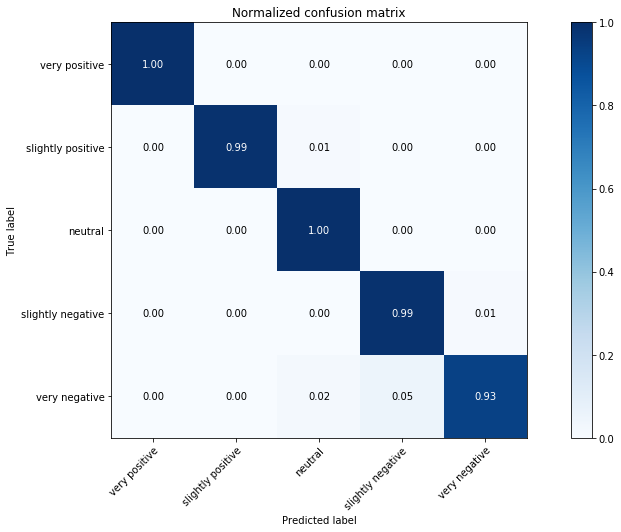

In [59]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ysvm_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ysvm_pred))

plot_confusion_matrix(y_test, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [60]:
#Create pipeline with our tf-idf vectorizer and SVM model
svm_model = Pipeline([
    ('tfidf', vect),
    ('clf', svc),
])

In [61]:
filename = 'tfidf_svm.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [64]:
model = pickle.load(open(filename, 'rb'))

message = 'happy to see you' 
model.predict([message])

array([3], dtype=int64)